<a href="https://colab.research.google.com/github/Abhinanda24/LLM_lab/blob/main/Copy_of_Experiment_no_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Tokens from NLTK corpus: ['the', 'fulton', 'county', 'grand', 'jury', 'said']
Vocabulary: {'grand': 0, 'the': 1, 'said': 2, 'county': 3, 'jury': 4, 'fulton': 5}
Word indices: tensor([[1, 5, 3, 0, 4, 2]])
Embedding tensor shape: torch.Size([1, 6, 8])

SELF-ATTENTION
Output shape: torch.Size([1, 6, 8])
Attention weight shape: torch.Size([1, 6, 6])


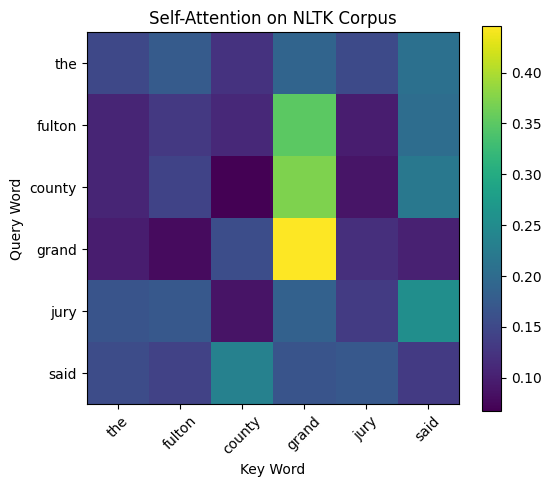


MULTI-HEAD ATTENTION
Output shape: torch.Size([1, 6, 8])
Attention weight shape: torch.Size([1, 2, 6, 6])


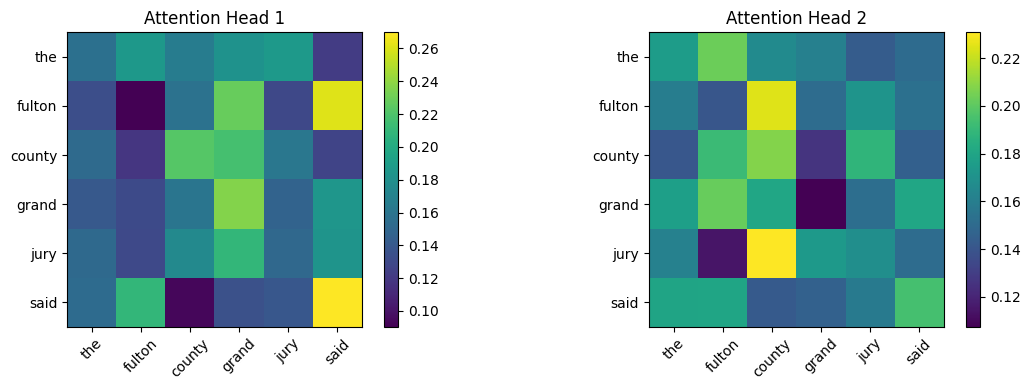


FINAL OBSERVATION:
- Attention is applied on real corpus words
- Self-attention produces ONE attention map
- Multi-head attention produces MULTIPLE maps
- Different heads capture different relationships
- This is the core idea behind Transformers


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import brown

nltk.download('brown')

torch.manual_seed(1)

words = brown.words()[:6]

tokens = [word.lower() for word in words]

print("Tokens from NLTK corpus:", tokens)


vocab = {word: idx for idx, word in enumerate(set(tokens))}

print("Vocabulary:", vocab)

indices = torch.tensor([[vocab[word] for word in tokens]])

print("Word indices:", indices)

embedding_dim = 8

embedding_layer = nn.Embedding(
    num_embeddings=len(vocab),
    embedding_dim=embedding_dim
)

x = embedding_layer(indices)

print("Embedding tensor shape:", x.shape)


class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        """
        Constructor for Self-Attention layer.

        Purpose:
        - Define trainable layers (Q, K, V)
        - No data processing happens here
        """
        super(SelfAttention, self).__init__()

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)


        self.scale = embed_dim ** 0.5

    def forward(self, x):
        """
        Forward pass defines HOW attention is computed.

        Input:
        x → (batch_size, sequence_length, embedding_dim)
        """


        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        scores = torch.matmul(Q, K.transpose(-2, -1))

        scores = scores / self.scale

        attention_weights = F.softmax(scores, dim=-1)

        output = torch.matmul(attention_weights, V)

        return output, attention_weights




class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        """
        Constructor for Multi-Head Attention.

        embed_dim → total embedding size
        num_heads → number of parallel attention heads
        The constructor is where we build the layer.”

           In __init__() we:

           Define trainable parameters

           Create layers

           Set hyperparameters


        """
        super(MultiHeadAttention, self).__init__()


        assert embed_dim % num_heads == 0

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)


        self.fc = nn.Linear(embed_dim, embed_dim)

        self.scale = self.head_dim ** 0.5

    def forward(self, x):
        """
        Performs multi-head attention.
        The forward pass defines how data flows through the model.
        Input:
        x → (batch_size, sequence_length, embed_dim)
        """
        B, T, D = x.shape


        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)


        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)


        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_weights = F.softmax(scores, dim=-1)


        out = torch.matmul(attention_weights, V)


        out = out.transpose(1, 2).contiguous().view(B, T, D)

        out = self.fc(out)

        return out, attention_weights




self_attn = SelfAttention(embed_dim=embedding_dim)
sa_output, sa_weights = self_attn(x)

print("\nSELF-ATTENTION")
print("Output shape:", sa_output.shape)
print("Attention weight shape:", sa_weights.shape)

plt.figure(figsize=(6, 5))
plt.imshow(sa_weights[0].detach().numpy(), cmap="viridis")
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title("Self-Attention on NLTK Corpus")
plt.xlabel("Key Word")
plt.ylabel("Query Word")
plt.show()


mha = MultiHeadAttention(embed_dim=embedding_dim, num_heads=2)
mha_output, mha_weights = mha(x)

print("\nMULTI-HEAD ATTENTION")
print("Output shape:", mha_output.shape)
print("Attention weight shape:", mha_weights.shape)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for h in range(2):
    im = axes[h].imshow(
        mha_weights[0, h].detach().numpy(),
        cmap="viridis"
    )
    axes[h].set_xticks(range(len(tokens)))
    axes[h].set_yticks(range(len(tokens)))
    axes[h].set_xticklabels(tokens, rotation=45)
    axes[h].set_yticklabels(tokens)
    axes[h].set_title(f"Attention Head {h+1}")

    plt.colorbar(im, ax=axes[h], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\nFINAL OBSERVATION:")
print("- Attention is applied on real corpus words")
print("- Self-attention produces ONE attention map")
print("- Multi-head attention produces MULTIPLE maps")
print("- Different heads capture different relationships")
print("- This is the core idea behind Transformers")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')